This notebook has been archived to `notebooks/archive_notebooks/08_final_analysis_2015_2019.ipynb`.

Full exploratory content was moved to the `archive_notebooks/` folder to keep the workspace minimal. If you need the original, open the archived file or recover it from git history.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Setup complete")

✓ Setup complete


## Load All Periods

In [ ]:
df = pd.read_csv('../data/processed/full_processed_data_hmm.csv', index_col=0, parse_dates=True)

# Split into periods
data_2015_2019 = df.loc['2015-01-01':'2019-12-31'].copy()
data_2020_2024 = df.loc['2020-01-01':'2024-12-31'].copy()
data_2025 = df.loc['2025-01-01':'2025-12-31'].copy()

print("Data periods loaded:")
print(f"  2015-2019: {len(data_2015_2019)} obs ({data_2015_2019.index.min().date()} to {data_2015_2019.index.max().date()})")
print(f"  2020-2024: {len(data_2020_2024)} obs ({data_2020_2024.index.min().date()} to {data_2020_2024.index.max().date()})")
print(f"  2025:      {len(data_2025)} obs ({data_2025.index.min().date()} to {data_2025.index.max().date()})")

# Compare spread statistics across periods
print("\n" + "="*80)
print("SPREAD STATISTICS BY PERIOD")
print("="*80)

periods = {
    '2015-2019': data_2015_2019,
    '2020-2024': data_2020_2024,
    '2025': data_2025
}

stats_comparison = []
for name, data in periods.items():
    stats_comparison.append({
        'Period': name,
        'Mean (bps)': data['spread'].mean(),
        'Std (bps)': data['spread'].std(),
        'Min (bps)': data['spread'].min(),
        'Max (bps)': data['spread'].max(),
        'Range (bps)': data['spread'].max() - data['spread'].min(),
    })

stats_df = pd.DataFrame(stats_comparison)
print("\n" + stats_df.to_string(index=False))

Data periods loaded:
  2015-2019: 1302 obs (2015-01-29 to 2019-12-31)
  2020-2024: 1322 obs (2020-01-01 to 2024-12-31)
  2025:      263 obs (2025-01-01 to 2025-12-30)

SPREAD STATISTICS BY PERIOD

   Period  Mean (bps)  Std (bps)  Min (bps)  Max (bps)  Range (bps)
2015-2019    1.330614   0.240889       0.90       2.21         1.31
2020-2024    1.225408   0.383522       0.77       4.01         3.24
     2025    0.856464   0.099295       0.74       1.21         0.47


## Visualize Spread Evolution

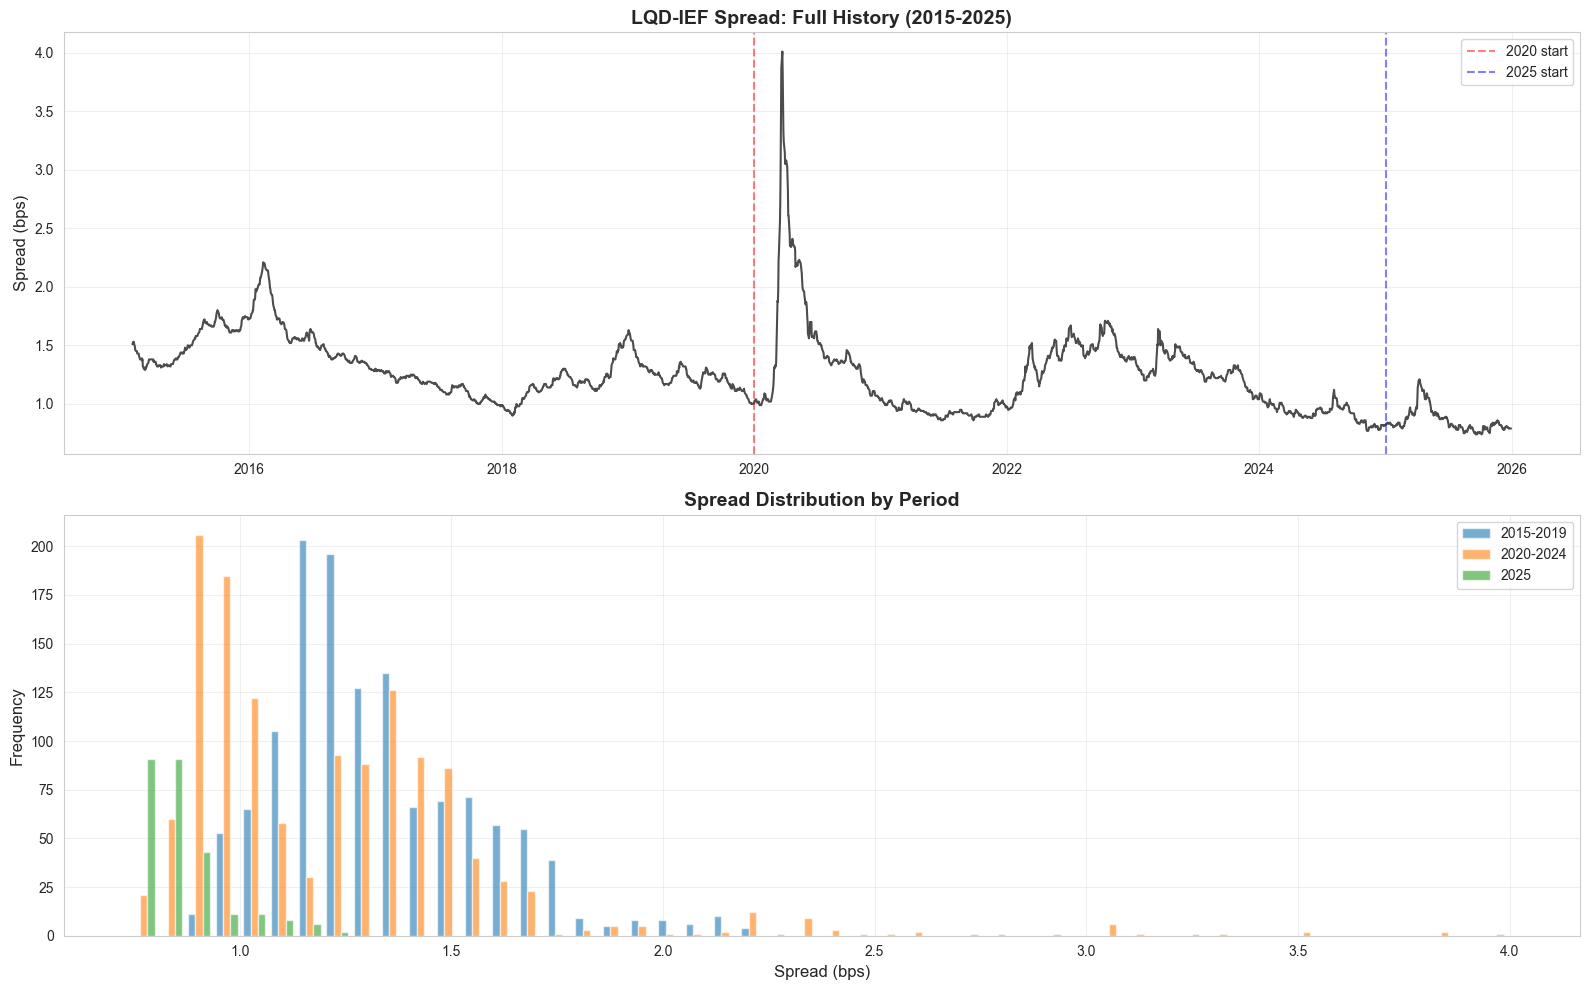

✓ Spread evolution visualized


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Full time series
axes[0].plot(df.index, df['spread'], linewidth=1.5, color='black', alpha=0.7)
axes[0].axvline(x=pd.Timestamp('2020-01-01'), color='red', linestyle='--', alpha=0.5, label='2020 start')
axes[0].axvline(x=pd.Timestamp('2025-01-01'), color='blue', linestyle='--', alpha=0.5, label='2025 start')
axes[0].set_ylabel('Spread (bps)', fontsize=12)
axes[0].set_title('LQD-IEF Spread: Full History (2015-2025)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# By period
axes[1].hist([data_2015_2019['spread'], data_2020_2024['spread'], data_2025['spread']], 
             bins=50, alpha=0.6, label=['2015-2019', '2020-2024', '2025'])
axes[1].set_xlabel('Spread (bps)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Spread Distribution by Period', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/spread_evolution_all_periods.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Spread evolution visualized")

## Test Strategies on 2015-2019

In [ ]:
def backtest_simple_zscore(data, window=60, entry_z=2.0, exit_z=0.5, position_size=0.5, capital=1_000_000):
    results = []
    position = 0
    equity = capital
    notional = capital * position_size
    
    for i in range(window, len(data)):
        current_spread = data['spread'].iloc[i]
        regime = data['regime'].iloc[i]
        vix = data['vix'].iloc[i]
        
        hist = data['spread'].iloc[i-window:i]
        mean = hist.mean()
        std = hist.std()
        z_score = (current_spread - mean) / std if std > 0 else 0
        
        signal = position
        if position != 0 and abs(z_score) < exit_z:
            signal = 0
        elif position == 0:
            if z_score > entry_z:
                signal = -1
            elif z_score < -entry_z:
                signal = +1
        
        if regime == 1:
            if position == 0:
                signal = 0
            else:
                signal = 0
        if vix > 30 and position == 0:
            signal = 0
        
        pnl = 0
        if i > window and position != 0:
            spread_chg = (current_spread - data['spread'].iloc[i-1]) / 10000
            pnl = spread_chg * notional if position == 1 else -spread_chg * notional
        
        equity += pnl
        position = signal
        results.append({'spread': current_spread, 'z_score': z_score, 'position': position, 'pnl': pnl, 'equity': equity})
    
    return pd.DataFrame(results, index=data.index[window:])

def backtest_absolute(data, short_threshold=1.5, long_threshold=0.9, exit_level=1.2, position_size=0.5, capital=1_000_000):
    results = []
    position = 0
    equity = capital
    notional = capital * position_size
    
    for i in range(1, len(data)):
        current_spread = data['spread'].iloc[i]
        regime = data['regime'].iloc[i]
        vix = data['vix'].iloc[i]
        
        signal = position
        if position == 1 and current_spread > exit_level:
            signal = 0
        elif position == -1 and current_spread < exit_level:
            signal = 0
        elif position == 0:
            if current_spread > short_threshold:
                signal = -1
            elif current_spread < long_threshold:
                signal = +1
        
        if regime == 1:
            if position == 0:
                signal = 0
            else:
                signal = 0
        if vix > 30 and position == 0:
            signal = 0
        
        pnl = 0
        if position != 0:
            spread_chg = (current_spread - data['spread'].iloc[i-1]) / 10000
            pnl = spread_chg * notional if position == 1 else -spread_chg * notional
        
        equity += pnl
        position = signal
        results.append({'spread': current_spread, 'position': position, 'pnl': pnl, 'equity': equity})
    
    return pd.DataFrame(results, index=data.index[1:])

print("✓ Strategy functions loaded")

✓ Strategy functions loaded


In [ ]:
print("Testing Strategies on 2015-2019 (ZERO COSTS)")
print("="  * 80)

# Run strategies on 2015-2019
results_zscore_2015 = backtest_simple_zscore(data_2015_2019, window=60, entry_z=2.0, exit_z=0.5)
results_abs_2015 = backtest_absolute(data_2015_2019, short_threshold=1.5, long_threshold=0.9, exit_level=1.2)

# Calculate metrics
def calc_metrics(results, capital=1_000_000):
    total_ret = (results['equity'].iloc[-1] - capital) / capital
    daily_ret = results['pnl'] / capital
    sharpe = (daily_ret.mean() / daily_ret.std()) * np.sqrt(252) if daily_ret.std() > 0 else 0
    running_max = results['equity'].expanding().max()
    dd = (results['equity'] - running_max) / running_max
    max_dd = dd.min()
    n_trades = (results['position'].diff().fillna(0) != 0).sum() // 2
    win_days = (daily_ret > 0).sum()
    lose_days = (daily_ret < 0).sum()
    win_rate = win_days / (win_days + lose_days) if (win_days + lose_days) > 0 else 0
    
    return {
        'return': total_ret,
        'sharpe': sharpe,
        'max_dd': max_dd,
        'trades': int(n_trades),
        'win_rate': win_rate,
        'final_equity': results['equity'].iloc[-1],
    }

metrics_zscore_2015 = calc_metrics(results_zscore_2015)
metrics_abs_2015 = calc_metrics(results_abs_2015)

comparison_2015 = pd.DataFrame({
    'Simple Z-Score': metrics_zscore_2015,
    'Absolute Levels': metrics_abs_2015,
})

print("\n2015-2019 Results:")
print(comparison_2015.T.to_string())

print(f"\n\nSummary:")
for strategy in ['Simple Z-Score', 'Absolute Levels']:
    print(f"\n{strategy}:")
    print(f"  Return: {comparison_2015.loc['return', strategy]:.2%}")
    print(f"  Sharpe: {comparison_2015.loc['sharpe', strategy]:.2f}")
    print(f"  Trades: {int(comparison_2015.loc['trades', strategy])}")
    print(f"  Final equity: ${comparison_2015.loc['final_equity', strategy]:,.2f}")
    print(f"  P&L: ${comparison_2015.loc['final_equity', strategy] - 1_000_000:,.2f}")

Testing Strategies on 2015-2019 (ZERO COSTS)

2015-2019 Results:
                   return    sharpe    max_dd  trades  win_rate  final_equity
Simple Z-Score  -0.000044 -1.716344 -0.000044    12.0  0.386364      999956.5
Absolute Levels  0.000036  1.480087 -0.000020     6.0  0.601810     1000036.0


Summary:

Simple Z-Score:
  Return: -0.00%
  Sharpe: -1.72
  Trades: 12
  Final equity: $999,956.50
  P&L: $-43.50

Absolute Levels:
  Return: 0.00%
  Sharpe: 1.48
  Trades: 6
  Final equity: $1,000,036.00
  P&L: $36.00


## Cross-Period Comparison

In [ ]:
# Run on all periods for comparison
results_2020 = backtest_absolute(data_2020_2024, short_threshold=1.5, long_threshold=0.9, exit_level=1.2)
results_2025_abs = backtest_absolute(data_2025, short_threshold=1.5, long_threshold=0.9, exit_level=1.2)

metrics_2015 = calc_metrics(results_abs_2015)
metrics_2020 = calc_metrics(results_2020)
metrics_2025_abs = calc_metrics(results_2025_abs)

# Create cross-period comparison
cross_period = pd.DataFrame({
    '2015-2019': metrics_2015,
    '2020-2024': metrics_2020,
    '2025': metrics_2025_abs,
})

print("\n" + "="*80)
print("CROSS-PERIOD COMPARISON: ABSOLUTE LEVELS STRATEGY (ZERO COSTS)")
print("="*80)
print("\n" + cross_period.T.to_string())

# Calculate P&L for each period
print("\n\nP&L Summary:")
for period in ['2015-2019', '2020-2024', '2025']:
    pnl = cross_period.loc['final_equity', period] - 1_000_000
    print(f"  {period}: ${pnl:,.2f}")


CROSS-PERIOD COMPARISON: ABSOLUTE LEVELS STRATEGY (ZERO COSTS)

             return    sharpe    max_dd  trades  win_rate  final_equity
2015-2019  0.000036  1.480087 -0.000020     6.0  0.601810     1000036.0
2020-2024  0.000013  0.623482 -0.000005     4.0  0.525180     1000013.0
2025      -0.000001 -0.123328 -0.000007     1.0  0.479339      999999.0


P&L Summary:
  2015-2019: $36.00
  2020-2024: $13.00
  2025: $-1.00


## Visualize Cross-Period Performance

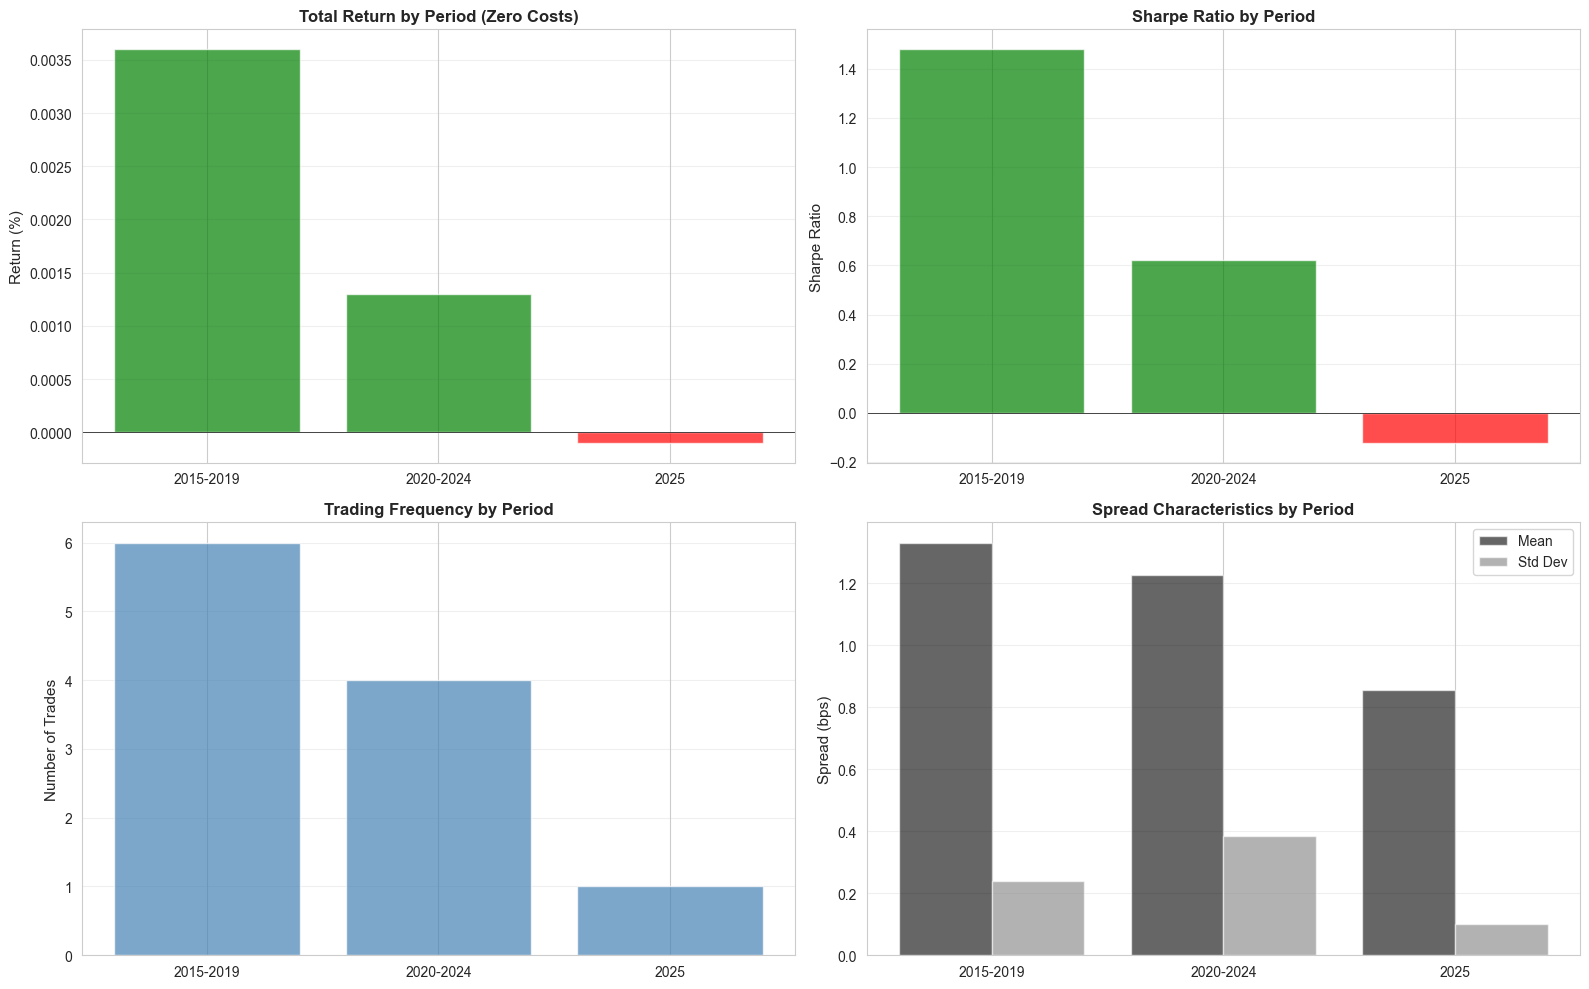

✓ Cross-period comparison complete


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Returns by period
returns = [cross_period.loc['return', p] * 100 for p in ['2015-2019', '2020-2024', '2025']]
axes[0, 0].bar(['2015-2019', '2020-2024', '2025'], returns, color=['green' if r > 0 else 'red' for r in returns], alpha=0.7)
axes[0, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0, 0].set_ylabel('Return (%)', fontsize=11)
axes[0, 0].set_title('Total Return by Period (Zero Costs)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Sharpe by period
sharpes = [cross_period.loc['sharpe', p] for p in ['2015-2019', '2020-2024', '2025']]
axes[0, 1].bar(['2015-2019', '2020-2024', '2025'], sharpes, color=['green' if s > 0 else 'red' for s in sharpes], alpha=0.7)
axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0, 1].set_ylabel('Sharpe Ratio', fontsize=11)
axes[0, 1].set_title('Sharpe Ratio by Period', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Trades by period
trades = [int(cross_period.loc['trades', p]) for p in ['2015-2019', '2020-2024', '2025']]
axes[1, 0].bar(['2015-2019', '2020-2024', '2025'], trades, color='steelblue', alpha=0.7)
axes[1, 0].set_ylabel('Number of Trades', fontsize=11)
axes[1, 0].set_title('Trading Frequency by Period', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Spread characteristics
spread_means = [data_2015_2019['spread'].mean(), data_2020_2024['spread'].mean(), data_2025['spread'].mean()]
spread_stds = [data_2015_2019['spread'].std(), data_2020_2024['spread'].std(), data_2025['spread'].std()]
x_pos = np.arange(3)
axes[1, 1].bar(x_pos - 0.2, spread_means, width=0.4, label='Mean', color='black', alpha=0.6)
axes[1, 1].bar(x_pos + 0.2, spread_stds, width=0.4, label='Std Dev', color='gray', alpha=0.6)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(['2015-2019', '2020-2024', '2025'])
axes[1, 1].set_ylabel('Spread (bps)', fontsize=11)
axes[1, 1].set_title('Spread Characteristics by Period', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/figures/cross_period_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Cross-period comparison complete")